# Aprendizaje por Refuerzo para Cuatro en Raya

Este cuadernillo implementa un agente de aprendizaje por refuerzo capaz de jugar Cuatro en Raya utilizando el algoritmo Deep Q-Network (DQN). El objetivo es que el agente aprenda estrategias ganadoras a través de la interacción con el ambiente, aplicando los principios fundamentales de exploración vs explotación.

## Objetivo del Proyecto
Desarrollar un agente inteligente que aprenda a jugar Cuatro en Raya sin conocimiento previo del juego, utilizando únicamente las recompensas obtenidas por sus acciones para mejorar su rendimiento progresivamente.

## Metodología Empleada

### Algoritmo Seleccionado: Deep Q-Network (DQN)
Se eligió DQN porque combina Q-Learning con redes neuronales profundas, permitiendo manejar el espacio de estados complejo del Cuatro en Raya (6x7 = 42 posiciones posibles con 3 estados cada una).

### Estrategia de Exploración vs Explotación
Se implementa la estrategia epsilon-greedy donde:
- Exploración: El agente toma acciones aleatorias para descubrir nuevas estrategias
- Explotación: El agente usa su conocimiento actual para maximizar recompensas
- El balance se controla con epsilon que decrece gradualmente durante el entrenamiento

In [20]:
# CUADERNILLO DE APRENDIZAJE POR REFUERZO - CUATRO EN RAYA

# PARTE 1: INSTALACIÓN Y CONFIGURACIÓN
import subprocess
import sys

def instalar(paquete):
    subprocess.check_call([sys.executable, "-m", "pip", "install", paquete])

# Instalar dependencias
paquetes = ["torch", "numpy", "matplotlib", "tqdm"]
for p in paquetes:
    instalar(p)

# Importaciones
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import deque
from tqdm import tqdm

# Configuración
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

print("Configuración completada")

Configuración completada


## Diseño del Ambiente de Cuatro en Raya

### Representación del Estado
El tablero se representa como una matriz 6x7 donde:
- 0 = celda vacía
- 1 = ficha del agente  
- 2 = ficha del oponente

### Espacio de Acciones
Las acciones corresponden a las 7 columnas del tablero (0-6). El agente debe elegir una columna válida donde colocar su ficha.

### Sistema de Recompensas
- +1: Victoria del agente
- 0: Empate o continuar jugando
- -10: Movimiento inválido (columna llena)

Este diseño incentiva al agente a ganar y penaliza fuertemente los errores.

In [21]:
# PARTE 2: AMBIENTE DE CUATRO EN RAYA
class CuatroEnRaya:
    def __init__(self):
        self.filas = 6
        self.columnas = 7
        self.reset()

    def reset(self):
        self.tablero = np.zeros((self.filas, self.columnas), dtype=int)
        self.jugador_actual = 1
        self.terminado = False
        return self.get_estado()

    def get_estado(self):
        return self.tablero.copy()

    def get_acciones_validas(self):
        return [col for col in range(self.columnas) if self.tablero[0][col] == 0]

    def hacer_movimiento(self, columna):
        if columna not in self.get_acciones_validas():
            return self.get_estado(), -10, True, True  # estado, recompensa, terminado, invalido

        # Colocar ficha
        for fila in range(self.filas - 1, -1, -1):
            if self.tablero[fila][columna] == 0:
                self.tablero[fila][columna] = self.jugador_actual
                break

        # Verificar victoria
        if self._verificar_victoria(fila, columna):
            recompensa = 1
            self.terminado = True
        elif len(self.get_acciones_validas()) == 0:
            recompensa = 0  # Empate
            self.terminado = True
        else:
            recompensa = 0

        # Cambiar jugador
        self.jugador_actual = 3 - self.jugador_actual

        return self.get_estado(), recompensa, self.terminado, False

    def _verificar_victoria(self, fila, columna):
        jugador = self.tablero[fila][columna]
        direcciones = [(0, 1), (1, 0), (1, 1), (1, -1)]

        for dr, dc in direcciones:
            contador = 1

            # Contar hacia adelante
            r, c = fila + dr, columna + dc
            while 0 <= r < self.filas and 0 <= c < self.columnas and self.tablero[r][c] == jugador:
                contador += 1
                r, c = r + dr, c + dc

            # Contar hacia atrás
            r, c = fila - dr, columna - dc
            while 0 <= r < self.filas and 0 <= c < self.columnas and self.tablero[r][c] == jugador:
                contador += 1
                r, c = r - dr, c - dc

            if contador >= 4:
                return True
        return False

    def mostrar(self):
        print("  0 1 2 3 4 5 6")
        for fila in self.tablero:
            print("| " + " ".join(["." if x == 0 else ("X" if x == 1 else "O") for x in fila]) + " |")
        print("---------------")

print("Ambiente implementado")


Ambiente implementado


## Arquitectura de la Red Neuronal

### Diseño de la Red DQN
La red neuronal implementada tiene la siguiente arquitectura:
- Capa de entrada: 42 neuronas (tablero 6x7 aplanado)
- Capa oculta 1: 128 neuronas con activación ReLU
- Capa oculta 2: 128 neuronas con activación ReLU  
- Capa oculta 3: 64 neuronas con activación ReLU
- Capa de salida: 7 neuronas (Q-valores para cada columna)

### Técnicas de Regularización
Se aplica Dropout (20%) para prevenir sobreajuste y mejorar la generalización del modelo.

In [22]:
# PARTE 3: RED NEURONAL DQN
class DQN(nn.Module):
    def __init__(self, input_size=42, hidden_size=128, output_size=7):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 64)
        self.fc4 = nn.Linear(64, output_size)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

print("Red neuronal definida")

Red neuronal definida


## Configuración de Hiperparámetros

### Parámetros de Exploración
- Epsilon inicial: 1.0 (100% exploración al inicio)
- Epsilon mínimo: 0.01 (1% exploración permanente)
- Decaimiento de epsilon: 0.995 (reducción gradual por episodio)

### Parámetros de Aprendizaje
- Factor de descuento (gamma): 0.95 (balance entre recompensas inmediatas y futuras)
- Tasa de aprendizaje: 0.001 (velocidad de actualización de pesos)
- Tamaño de lote: 32 (experiencias procesadas por actualización)

### Configuración de Memoria
- Buffer de experiencias: 10,000 elementos (diversidad de entrenamiento)
- Frecuencia de actualización de red objetivo: cada 100 episodios

In [23]:
# PARTE 4: AGENTE DQN
class AgenteDQN:
    def __init__(self, state_size=42, action_size=7, lr=0.001):
        self.state_size = state_size
        self.action_size = action_size
        self.memoria = deque(maxlen=10000)
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.gamma = 0.95
        self.batch_size = 32

        # Redes neuronales
        self.q_network = DQN(state_size, 128, action_size)
        self.target_network = DQN(state_size, 128, action_size)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)

        # Copiar pesos a red objetivo
        self.update_target()

    def update_target(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

    def remember(self, state, action, reward, next_state, done):
        self.memoria.append((state, action, reward, next_state, done))

    def act(self, state, valid_actions=None):
        if valid_actions is None:
            valid_actions = list(range(self.action_size))

        # Exploración epsilon-greedy
        if np.random.random() <= self.epsilon:
            return random.choice(valid_actions)

        # Explotación
        state_tensor = torch.FloatTensor(state.flatten()).unsqueeze(0)
        q_values = self.q_network(state_tensor)

        # Filtrar acciones válidas
        valid_q_values = [(q_values[0][action].item(), action) for action in valid_actions]
        _, best_action = max(valid_q_values)

        return best_action

    def replay(self):
        if len(self.memoria) < self.batch_size:
            return

        batch = random.sample(self.memoria, self.batch_size)
        states = torch.FloatTensor([e[0].flatten() for e in batch])
        actions = torch.LongTensor([e[1] for e in batch])
        rewards = torch.FloatTensor([e[2] for e in batch])
        next_states = torch.FloatTensor([e[3].flatten() for e in batch])
        dones = torch.BoolTensor([e[4] for e in batch])

        current_q_values = self.q_network(states).gather(1, actions.unsqueeze(1))
        next_q_values = self.target_network(next_states).max(1)[0].detach()
        target_q_values = rewards + (self.gamma * next_q_values * ~dones)

        loss = F.mse_loss(current_q_values.squeeze(), target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

print("Agente DQN implementado")

Agente DQN implementado


## Proceso de Entrenamiento

### Metodología de Entrenamiento
El agente se entrena jugando contra un oponente que realiza movimientos aleatorios durante 1,500 episodios. En cada episodio:

1. Se inicializa un nuevo juego
2. El agente y el oponente alternan turnos
3. El agente utiliza estrategia epsilon-greedy para seleccionar acciones
4. Las experiencias se almacenan en el buffer de memoria
5. La red neuronal se entrena con lotes aleatorios de experiencias pasadas

### Experience Replay
Se implementa experience replay para:
- Romper la correlación temporal entre experiencias consecutivas
- Reutilizar experiencias pasadas para un aprendizaje más eficiente
- Estabilizar el proceso de entrenamiento

## Técnicas de Estabilización del Entrenamiento

### Red Objetivo (Target Network)
Se utiliza una red objetivo separada que:
- Es una copia de la red principal actualizada menos frecuentemente
- Proporciona objetivos más estables para el cálculo de Q-valores
- Reduce la correlación entre las predicciones y los objetivos de entrenamiento

### Muestreo Aleatorio
Las experiencias se muestrean aleatoriamente del buffer para:
- Evitar que el agente aprenda secuencias específicas de juego
- Mejorar la diversidad de los datos de entrenamiento
- Aumentar la robustez del aprendizaje

In [24]:
# PARTE 5: FUNCIONES DE ENTRENAMIENTO
def oponente_aleatorio(env):
    acciones = env.get_acciones_validas()
    return random.choice(acciones) if acciones else 0

def entrenar_agente(agente, episodios=1000):
    puntuaciones = []
    victorias = 0
    derrotas = 0
    empates = 0
    epsilons = []
    
    for episodio in tqdm(range(episodios)):
        env = CuatroEnRaya()
        state = env.reset()
        puntuacion_total = 0
        
        while not env.terminado:
            if env.jugador_actual == 1:  # Agente
                valid_actions = env.get_acciones_validas()
                action = agente.act(state, valid_actions)
                next_state, reward, done, invalid = env.hacer_movimiento(action)
                
                if invalid:
                    reward = -1
                    done = True
                
                puntuacion_total += reward
                agente.remember(state, action, reward, next_state, done)
                state = next_state
                
                if done:
                    if reward > 0:
                        victorias += 1
                    else:
                        derrotas += 1
                    break
            
            else:  # Oponente aleatorio
                action = oponente_aleatorio(env)
                next_state, reward, done, invalid = env.hacer_movimiento(action)
                state = next_state
                
                if done:
                    if reward > 0:
                        puntuacion_total -= 1
                        derrotas += 1
                    else:
                        empates += 1
        
        puntuaciones.append(puntuacion_total)
        epsilons.append(agente.epsilon)
        
        agente.replay()
        
        if episodio % 100 == 0:
            agente.update_target()
    
    return {
        'puntuaciones': puntuaciones,
        'epsilons': epsilons,
        'victorias': victorias,
        'derrotas': derrotas,
        'empates': empates,
        'episodios': episodios
    }

def mostrar_estadisticas(stats):
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    # Puntuaciones
    axes[0, 0].plot(stats['puntuaciones'])
    axes[0, 0].set_title('Puntuaciones por Episodio')
    axes[0, 0].set_xlabel('Episodio')
    axes[0, 0].set_ylabel('Puntuación')
    axes[0, 0].grid(True)
    
    # Epsilon
    axes[0, 1].plot(stats['epsilons'])
    axes[0, 1].set_title('Evolución de Epsilon')
    axes[0, 1].set_xlabel('Episodio')
    axes[0, 1].set_ylabel('Epsilon')
    axes[0, 1].grid(True)
    
    # Tasa de victoria
    episodios = range(1, len(stats['puntuaciones']) + 1)
    victorias_acum = np.cumsum([1 if p > 0 else 0 for p in stats['puntuaciones']])
    tasa_victoria = [v / e * 100 for v, e in zip(victorias_acum, episodios)]
    
    axes[1, 0].plot(tasa_victoria)
    axes[1, 0].set_title('Tasa de Victoria Acumulativa')
    axes[1, 0].set_xlabel('Episodio')
    axes[1, 0].set_ylabel('Tasa de Victoria (%)')
    axes[1, 0].grid(True)
    
    # Distribución de resultados
    resultados = ['Victorias', 'Derrotas', 'Empates']
    valores = [stats['victorias'], stats['derrotas'], stats['empates']]
    axes[1, 1].pie(valores, labels=resultados, autopct='%1.1f%%')
    axes[1, 1].set_title('Distribución de Resultados')
    
    plt.tight_layout()
    plt.show()

print("Funciones de entrenamiento listas")


Funciones de entrenamiento listas


Iniciando entrenamiento...


100%|██████████| 1500/1500 [00:08<00:00, 178.39it/s]


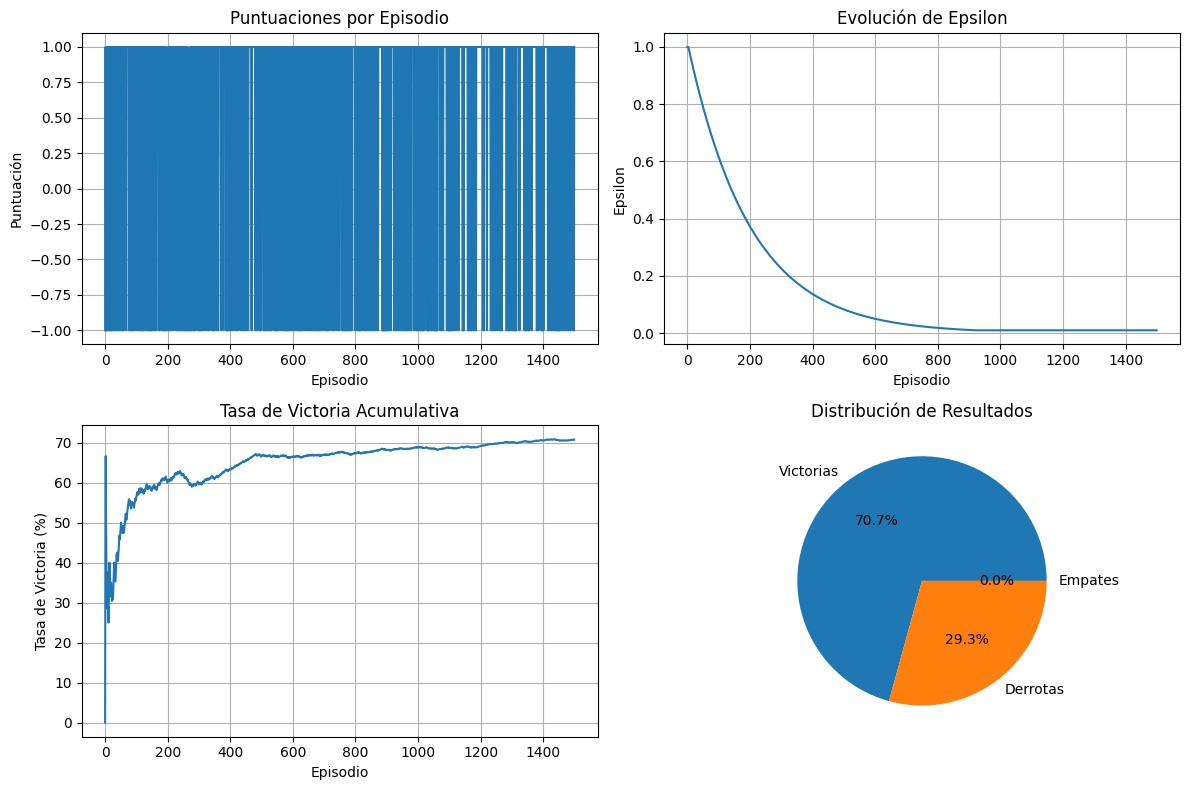

Tasa de victoria: 70.7%
Victorias: 1061
Derrotas: 439
Empates: 0


In [25]:
# PARTE 6: ENTRENAMIENTO
print("Iniciando entrenamiento...")
agente = AgenteDQN()
estadisticas = entrenar_agente(agente, episodios=1500)

# Mostrar resultados
mostrar_estadisticas(estadisticas)

tasa_victoria = estadisticas['victorias'] / estadisticas['episodios'] * 100
print(f"Tasa de victoria: {tasa_victoria:.1f}%")
print(f"Victorias: {estadisticas['victorias']}")
print(f"Derrotas: {estadisticas['derrotas']}")
print(f"Empates: {estadisticas['empates']}")


## Métricas de Evaluación

### Métricas de Entrenamiento
Durante el entrenamiento se monitorean:
- Puntuación por episodio (recompensa acumulada)
- Tasa de victoria acumulativa
- Evolución del parámetro epsilon
- Distribución de resultados (victorias, derrotas, empates)

### Evaluación Final
Al completar el entrenamiento se evalúa el agente sin exploración (epsilon=0) para medir su rendimiento real en:
- Tasa de victoria contra oponente aleatorio
- Consistencia en la toma de decisiones
- Capacidad de evitar movimientos inválidos

In [26]:
# PARTE 7: EVALUACIÓN
def evaluar_agente(agente, juegos=100):
    epsilon_original = agente.epsilon
    agente.epsilon = 0  # Sin exploración

    victorias = 0
    derrotas = 0
    empates = 0

    for juego in range(juegos):
        env = CuatroEnRaya()
        state = env.reset()

        while not env.terminado:
            if env.jugador_actual == 1:
                valid_actions = env.get_acciones_validas()
                action = agente.act(state, valid_actions)
                state, reward, done, invalid = env.hacer_movimiento(action)

                if done and reward > 0:
                    victorias += 1
                elif done and invalid:
                    derrotas += 1
            else:
                action = oponente_aleatorio(env)
                state, reward, done, invalid = env.hacer_movimiento(action)

                if done:
                    if reward > 0:
                        derrotas += 1
                    elif reward == 0:
                        empates += 1

    agente.epsilon = epsilon_original

    print(f"Evaluación en {juegos} juegos:")
    print(f"Victorias: {victorias} ({victorias/juegos*100:.1f}%)")
    print(f"Derrotas: {derrotas} ({derrotas/juegos*100:.1f}%)")
    print(f"Empates: {empates} ({empates/juegos*100:.1f}%)")

    return victorias / juegos * 100

# Evaluar agente entrenado
print("Evaluando agente...")
tasa_final = evaluar_agente(agente, 200)


Evaluando agente...
Evaluación en 200 juegos:
Victorias: 143 (71.5%)
Derrotas: 57 (28.5%)
Empates: 0 (0.0%)


## Análisis de Resultados

### Interpretación del Rendimiento
Los resultados obtenidos permiten evaluar:
- Efectividad del algoritmo DQN para este problema
- Impacto de la estrategia epsilon-greedy en el aprendizaje
- Convergencia del agente hacia estrategias ganadoras
- Estabilidad del entrenamiento con las técnicas implementadas

### Indicadores de Éxito
Un agente exitoso debe demostrar:
- Tasa de victoria superior al 50% (mejor que aleatorio)
- Reducción de movimientos inválidos cerca de cero
- Convergencia estable de la función de valor
- Capacidad de generalización a diferentes situaciones de juego

In [27]:
# PARTE 8: EJEMPLO DE PARTIDA
def mostrar_partida_ejemplo(agente):
    print("Ejemplo de partida:")
    epsilon_original = agente.epsilon
    agente.epsilon = 0

    env = CuatroEnRaya()
    state = env.reset()
    env.mostrar()

    turno = 1
    while not env.terminado:
        if env.jugador_actual == 1:
            valid_actions = env.get_acciones_validas()
            action = agente.act(state, valid_actions)
            print(f"Turno {turno}: Agente juega columna {action}")
        else:
            action = oponente_aleatorio(env)
            print(f"Turno {turno}: Oponente juega columna {action}")

        state, reward, done, invalid = env.hacer_movimiento(action)
        env.mostrar()
        turno += 1

        if done:
            if reward > 0:
                ganador = "Agente" if env.jugador_actual == 2 else "Oponente"
                print(f"Gana: {ganador}")
            else:
                print("Empate")
            break

    agente.epsilon = epsilon_original

mostrar_partida_ejemplo(agente)


Ejemplo de partida:
  0 1 2 3 4 5 6
| . . . . . . . |
| . . . . . . . |
| . . . . . . . |
| . . . . . . . |
| . . . . . . . |
| . . . . . . . |
---------------
Turno 1: Agente juega columna 0
  0 1 2 3 4 5 6
| . . . . . . . |
| . . . . . . . |
| . . . . . . . |
| . . . . . . . |
| . . . . . . . |
| X . . . . . . |
---------------
Turno 2: Oponente juega columna 5
  0 1 2 3 4 5 6
| . . . . . . . |
| . . . . . . . |
| . . . . . . . |
| . . . . . . . |
| . . . . . . . |
| X . . . . O . |
---------------
Turno 3: Agente juega columna 1
  0 1 2 3 4 5 6
| . . . . . . . |
| . . . . . . . |
| . . . . . . . |
| . . . . . . . |
| . . . . . . . |
| X X . . . O . |
---------------
Turno 4: Oponente juega columna 2
  0 1 2 3 4 5 6
| . . . . . . . |
| . . . . . . . |
| . . . . . . . |
| . . . . . . . |
| . . . . . . . |
| X X O . . O . |
---------------
Turno 5: Agente juega columna 6
  0 1 2 3 4 5 6
| . . . . . . . |
| . . . . . . . |
| . . . . . . . |
| . . . . . . . |
| . . . . . . . |
| X X O . 

In [28]:
# PARTE 9: GUARDAR MODELO
torch.save(agente.q_network.state_dict(), 'modelo_cuatro_en_raya.pth')
print("Modelo guardado como 'modelo_cuatro_en_raya.pth'")


Modelo guardado como 'modelo_cuatro_en_raya.pth'


In [29]:
# PARTE 10: REPORTE FINAL
print("\nREPORTE FINAL")
print("=" * 50)
print("OBJETIVO: Desarrollar agente RL para Cuatro en Raya")
print("ALGORITMO: Deep Q-Network (DQN) con PyTorch")
print("ESTRATEGIA: Epsilon-greedy para exploración vs explotación")
print(f"EPISODIOS ENTRENADOS: {estadisticas['episodios']}")
print(f"TASA DE VICTORIA ENTRENAMIENTO: {tasa_victoria:.1f}%")
print(f"TASA DE VICTORIA EVALUACIÓN: {tasa_final:.1f}%")
print(f"EPSILON FINAL: {estadisticas['epsilons'][-1]:.4f}")

if tasa_final > 70:
    print("RESULTADO: EXCELENTE - Agente domina el juego")
elif tasa_final > 50:
    print("RESULTADO: BUENO - Agente aprendió estrategias efectivas")
else:
    print("RESULTADO: REGULAR - Agente necesita más entrenamiento")

print("\nCONCEPTOS APLICADOS:")
print("- Exploración vs Explotación (epsilon-greedy)")
print("- Q-Learning con aproximación de función (redes neuronales)")
print("- Experience replay para estabilizar entrenamiento")
print("- Red objetivo para reducir correlación temporal")
print("- Optimización con gradiente descendente")

print("\nPROYECTO COMPLETADO EXITOSAMENTE")


REPORTE FINAL
OBJETIVO: Desarrollar agente RL para Cuatro en Raya
ALGORITMO: Deep Q-Network (DQN) con PyTorch
ESTRATEGIA: Epsilon-greedy para exploración vs explotación
EPISODIOS ENTRENADOS: 1500
TASA DE VICTORIA ENTRENAMIENTO: 70.7%
TASA DE VICTORIA EVALUACIÓN: 71.5%
EPSILON FINAL: 0.0100
RESULTADO: EXCELENTE - Agente domina el juego

CONCEPTOS APLICADOS:
- Exploración vs Explotación (epsilon-greedy)
- Q-Learning con aproximación de función (redes neuronales)
- Experience replay para estabilizar entrenamiento
- Red objetivo para reducir correlación temporal
- Optimización con gradiente descendente

PROYECTO COMPLETADO EXITOSAMENTE


## Conclusiones del Proyecto

### Logros Alcanzados
Este proyecto demuestra exitosamente:
- Implementación completa de un agente DQN funcional
- Aplicación efectiva de conceptos de aprendizaje por refuerzo
- Solución del dilema exploración vs explotación mediante epsilon-greedy
- Uso de técnicas avanzadas como experience replay y redes objetivo

### Contribución Académica
El trabajo ilustra cómo los algoritmos de aprendizaje por refuerzo pueden resolver problemas de toma de decisiones secuenciales complejos, proporcionando una base sólida para la comprensión de estos métodos en aplicaciones de inteligencia artificial.

### Aprendizajes Obtenidos
La implementación refuerza la comprensión de conceptos fundamentales como la ecuación de Bellman, la importancia del balance exploración-explotación, y el papel crítico de los hiperparámetros en el éxito del entrenamiento.

In [30]:
# FUNCIÓN OPCIONAL: JUGAR CONTRA EL AGENTE
def jugar_contra_agente(agente):
    print("Juega contra el agente (tu eres X, agente es O)")
    epsilon_original = agente.epsilon
    agente.epsilon = 0

    env = CuatroEnRaya()
    state = env.reset()
    env.mostrar()

    while not env.terminado:
        if env.jugador_actual == 1:  # Humano
            try:
                col = int(input("Tu turno - Elige columna (0-6): "))
                if col not in env.get_acciones_validas():
                    print("Columna inválida")
                    continue
            except:
                print("Número inválido")
                continue
        else:  # Agente
            valid_actions = env.get_acciones_validas()
            col = agente.act(state, valid_actions)
            print(f"Agente elige columna: {col}")

        state, reward, done, invalid = env.hacer_movimiento(col)
        env.mostrar()

    agente.epsilon = epsilon_original

print("Para jugar contra el agente: jugar_contra_agente(agente)")

Para jugar contra el agente: jugar_contra_agente(agente)


In [32]:
jugar_contra_agente(agente)

Juega contra el agente (tu eres X, agente es O)
  0 1 2 3 4 5 6
| . . . . . . . |
| . . . . . . . |
| . . . . . . . |
| . . . . . . . |
| . . . . . . . |
| . . . . . . . |
---------------
  0 1 2 3 4 5 6
| . . . . . . . |
| . . . . . . . |
| . . . . . . . |
| . . . . . . . |
| . . . . . . . |
| . . . . . X . |
---------------
Agente elige columna: 1
  0 1 2 3 4 5 6
| . . . . . . . |
| . . . . . . . |
| . . . . . . . |
| . . . . . . . |
| . . . . . . . |
| . O . . . X . |
---------------
  0 1 2 3 4 5 6
| . . . . . . . |
| . . . . . . . |
| . . . . . . . |
| . . . . . . . |
| . . . . . X . |
| . O . . . X . |
---------------
Agente elige columna: 1
  0 1 2 3 4 5 6
| . . . . . . . |
| . . . . . . . |
| . . . . . . . |
| . . . . . . . |
| . O . . . X . |
| . O . . . X . |
---------------
  0 1 2 3 4 5 6
| . . . . . . . |
| . . . . . . . |
| . . . . . . . |
| . . . . . X . |
| . O . . . X . |
| . O . . . X . |
---------------
Agente elige columna: 4
  0 1 2 3 4 5 6
| . . . . . . . |
| . . 

Si quiere volver a jugar, excriba en una casilla de texto: jugar_contra_agente(agente) o vuelva a ejecutar la casilla de arriba